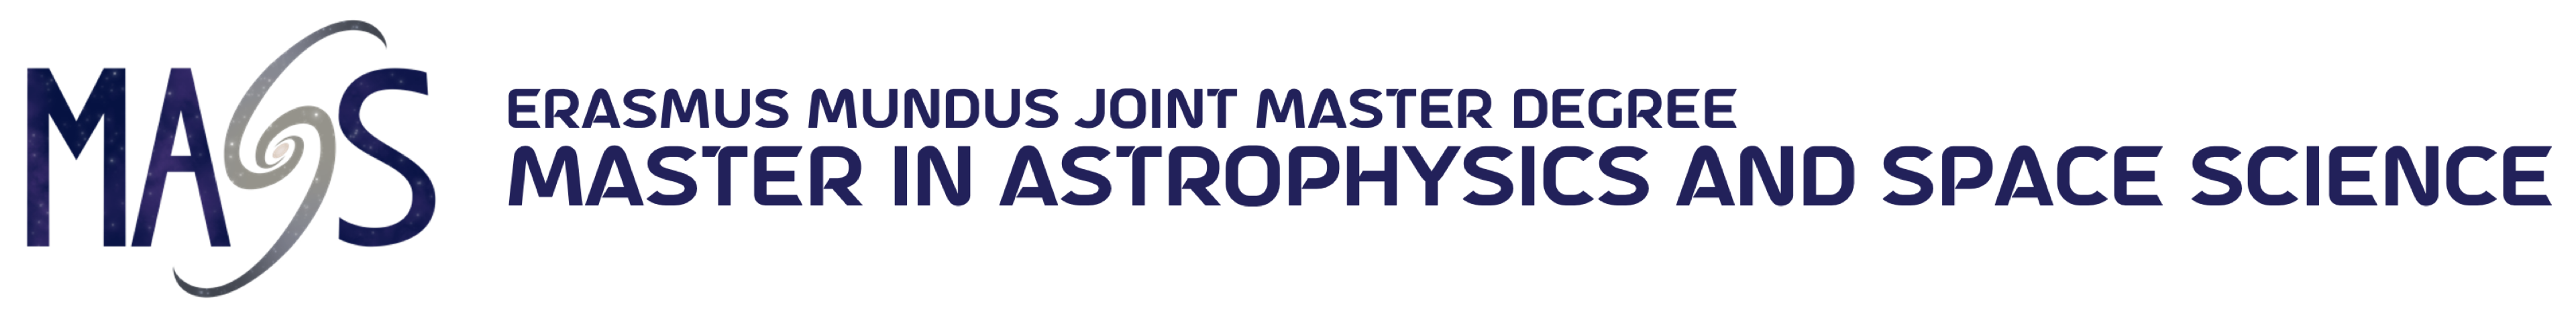

# AGNs Tutorial 4: Line fitting - Fantasy AGN

13 May 2024

Student: Francesca Borg

Instructor: Prof. Dragana Ilic

In this notebook, we follow the *'General Tutorial'* from [yakuwa1 on GitHub](https://github.com/yukawa1/fantasy/blob/main/docs/Tutorial.ipynb), by D. Ilić, N. Rakić. (Version: last modified May 2023), and expand on it by performing some additional tasks using FANTASY.

## General Tutorial

Open source code FANTASY (Fully Automated pythoN tool for AGN Spectra analYsis) is a python based code for simultaneous multi-component fitting of AGN spectra, optimized for the optical rest-frame band (3600-8000A), but also applicable to the UV range (2000-3600A) and NIR range (8000-11000A). 

The code fits simultaneously the underlying broken power-law continuum and sets of defined emission line lists. There is an option to import and fit together the Fe II model, to fully account for the rich emission of complex Fe II ion which can produce thousands of line transitions, both in the range of Hg and Hb, but also Ha line. The Fe II model is based on the atomic parameters of Fe II, and builds upon the models presented in <a href="https://ui.adsabs.harvard.edu/abs/2010ApJS..189...15K/abstract">Kovacevic et al. 2010</a>, <a href=https://ui.adsabs.harvard.edu/abs/2012ApJS..202...10S/abstract>Shapovalova et al. 2012</a>, and assumes that different Fe II lines are grouped according to the same lower energy level in the transition with line ratios connected through the line transition oscillatory strengths. The following multiplet in the range from 3800 to 11000A are used: e4D, e6D, z4F, z4D, z4P, a4G, a4H, b2H, b4D, b4F, b4P, a6S, a2D2, y4G, b4G, x4D, y4P (Ilic et al, 2023, submitted).

The code is flexible in the selection of different groups of lines, either already predefined lists (e.g., standard narrow lines, Hydrogen lines, Helium lines, other broad lines, forbidden Fe II lines, coronal lines, etc.), but gives full flexibility to the user to merge predefined line lists, create customized line list, etc. The code can be used either for fitting a single spectrum, as well as for the sample of spectra, which is illustrated in several given examples. It is an open source, easy to use code, available for installation through pip install option. It is based on Sherpa Python package (<a href="https://ui.adsabs.harvard.edu/abs/2022zndo...7186379B/abstract">Burke et al. 2022</a>).

In [1]:
#Before starting, we call some of the standard python packages, such as matplotlib, pandas, numpy, etc. 
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

import numpy as np
import pandas as pd

import glob

<font size=4> 1. Reading data </font>

First step involves reading a spectrum or set of spectra. We designed integrated three spectral classes: 
- read_sdss -  designed to read SDSS fits (https://www.sdss.org)
- read_gama_fits - designed to read GAMA fits (http://www.gama-survey.org)
- read_text - designed to read any ASCII files (e.g., wavelength, flux, flux_error)
- make_spec - designed to make Fantasy spectral class from any given three arrays for wavelength, flux, flux_error; user can also set the redshift and coordinates, which is needed in the later analysis: *make_spec(wave, flux, err, z=, ra=, dec=)*

The user has the possibility to read any other file format using prefered method.

In [2]:
# Below command import the above mentioned reading commands
from fantasy_agn.tools import read_sdss, read_text, read_gama_fits

# Below command import the necessary commands, which will be described later
from fantasy_agn.models import create_input_folder

from fantasy_agn.models import create_feii_model, create_model, create_tied_model, continuum, create_line, create_fixed_model

**Note**: Debugging required changing `Sherpafloat` to `SherpaFloat` in the file `/home/fran/miniconda3/envs/fantasyenv/lib/python3.9/site-packages/fantasy_agn/models.py`

In [3]:
# This command reads the spectrum with the listed name, from the folder of this notebook or 
# from the given path e.g.,'/path/to/files/spec*.txt'

s=read_sdss('spec-2770-54510-0433.fits')

<font size="4"> 2. Preparation of the spectra </font> 

Before performing the fittings, the FANTASY code provides several preprocessing options to prepare the spectrum, namely: 
- Setting wavelength frame from vacuum to air wavelengths - *vac_to_air()*.
- Galactic extinction correction - *DeRedden()*, based on <a href="https://ui.adsabs.harvard.edu/abs/1998ApJ...500..525S/abstract"> Schlegel, Finkbeiner, Davis (1998) </a> dust maps.
- redshift correction - *CorRed()*
- cropping/scaling of spectra - *crop(xmin,xmax)*

In [4]:
# We use for input models selected line lists, for which we provide air wavelengths
# If your spectrum is in vacuum wavelengths, this command transforms them to air wavelengths: s.vac_to_air()

# NOTE that read_sdss() transforms to air wavelengths by default.

In [5]:
# DeRedden() command corrects for the Galactic extinction, based on coordinates of the object provided in the fits, 
# which will be automatically derived from dust map data from Schlegel, Finkbeiner, Davis (1998).
# If coordinates are not available you could manually insert them using simple commands s.ra=xxx.xxx, s.dec=xxx.xxx

# s.ra=29.519807539582 #example input of arbitrary right ascension
# s.dec=-0.872742349310271 #example input of arbitrary declination

s.DeRedden()

In [6]:
# CorRed() corrects for the cosmological redshift, based on redshift of the object provided in the fits.
# If coordinates are not available you could manually insert them using simple command s.z=x.xxx

# s.z=0.0804 #example input of arbitrary redshift

s.CorRed()

In [7]:
# Useful tip is to avoid using very small flux units.
# e.g., SDSS spectra are given in 1e-17 erg/s/cm2/A and these are already scaled within read_sdss()

#s.flux=s.flux*10**17

<font size="4"> 3. Host-galaxy subtraction </font> 

Command *fit_host_sdss()* fits the observed spectrum using the approach already tested and used for SDSS spectra, which shows that the AGN spectra can be reconstructed as linear combinations of galaxy and quasar eigenspectra. Using the Principle Component Analysis (PCA), Yip et al. (2004a,b) constructed from 170,000 galaxy SDSS spectra and 16,707 quasar SDSS spectra, a set of galaxy and quasar eigenspectra. <a href="https://ui.adsabs.harvard.edu/abs/2006AJ....131...84V/abstract">Vanden Berk et al. (2006) </a> showed that majority of spectra can be reconstructed using the linear combination of 10 quasar eigenspectra from  <a href=”https://ui.adsabs.harvard.edu/abs/2004AJ....128.2603Y/abstract”>Yip et al. (2004b) </a> and 5 galaxy eigenspectra from  <a href=”https://ui.adsabs.harvard.edu/abs/2004AJ....128..585Y/abstract”>Yip et al. (2004a) </a>. For more details check the above references.

Command *fit_host()* fits the observed spectrum with PCA which uses all available eigenvectors (10 eignevectors for the galaxy (stellar) and 15 QSO components). In this case the code will test for different number of components until reaching best result based on the chi-squared parameter. 

In both cases, the weighted fit is used in order to avoid accounting for strong emission lines. If the host-galaxy contribution is negligible, i.e., the fitting results in a negative host-galaxy, the code will fail to find the host and inform the user.

**IMPORTANT:** Code will by default subtract the host galaxy from the observed spectrum; if you need the original spectrum for some analysis, you can restore the original spectrum before the host fitting with the command *restore()*.

- host-galaxy fitting and subtraction - *fit_host_sdss()*
- host-galaxy fitting and subtraction - *fit_host()*

**TIP:** Do not crop the spectrum before fitting for the host galaxy contribution, as the fittings strongly depends on the stellar absorption features that are more likely to be detected in a wider spectral range, i.e. the range in which the eigenvectors are provided (3600-8000A).

In [8]:
#s.restore() #command which restores to the original spectrum, before host-galaxy removal; 
s.fit_host_sdss()

Host contribution is negliglable


One possibility is to mask the narrow emission lines while performing the host galaxy fitting. This is done with setting the option *mask_host=True*, which by default masks all well-known nebular lines ([O III], [N II], [S II]), but customized list of emission lines can be also given.

In [9]:
s.restore() #command to restore the spectrum before host galaxy fitting and subtraction
s.fit_host_sdss(mask_host=True, custom=False)

Host contribution is negliglable


Text(0.5, 0, 'Wavelength [$\\AA$]')

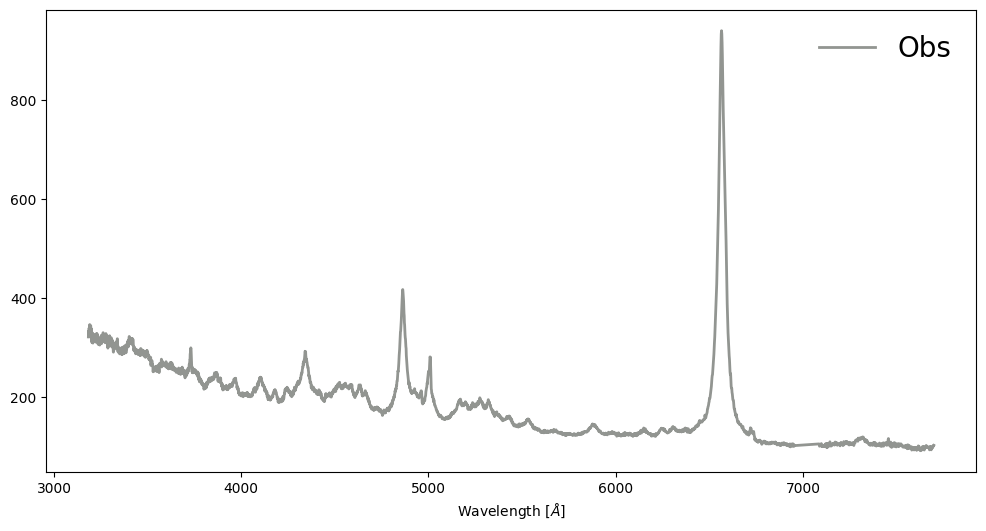

In [10]:
#Let's plot the spectrum for visual inspection.
plt.style.context(['nature', 'notebook'])
plt.figure(figsize=(12,6))
plt.plot(s.wave, s.flux, color="#929591", label='Obs', lw=2)
plt.legend(loc='upper right',  prop={'size': 20}, frameon=False, ncol=2)
plt.xlabel(r'Wavelength [$\AA$]')

It is obvious, e.g. based on the strong blue continuum and absence of absorption line, that the stellar contribution from the host galaxy can be negligible.

Let us try another example spectrum, e.g. G09_Y1_GS1_080.fit. now from the GAMMA database, which is a low-luminosity host-dominated AGN at $z=0.05488$.

**TIP:** The spectrum is very noisy in the blue part, therefore we crop the spectrum to 3900-8000A wavelength range, to avoid the noise, which is impossible to reproduce with the PCA, but leaving the strong stellar absorption features below 4000 A, i.e., Ca II resonance lines H(3968) and K(3933).

Text(0.5, 0, 'Wavelength [$\\AA$]')

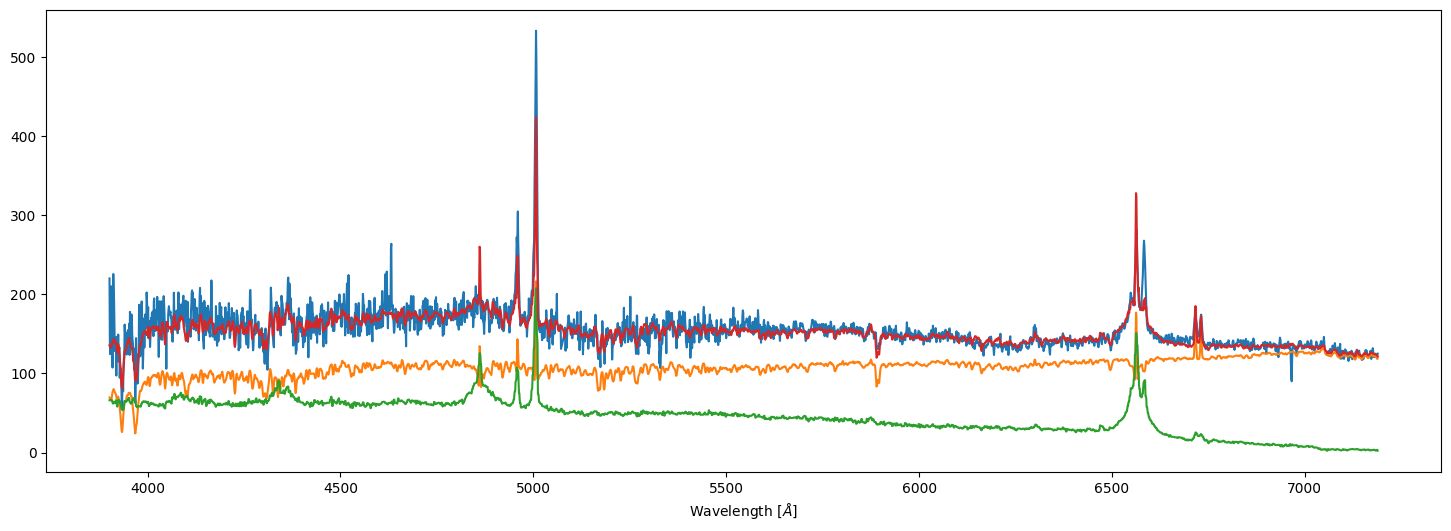

In [11]:
g=read_gama_fits('G09_Y1_GS1_080.fit')
g.DeRedden()
g.CorRed()
g.crop(3900,8000)
g.fit_host_sdss()
plt.xlabel(r'Wavelength [$\AA$]')

Text(0.5, 0, 'Wavelength [$\\AA$]')

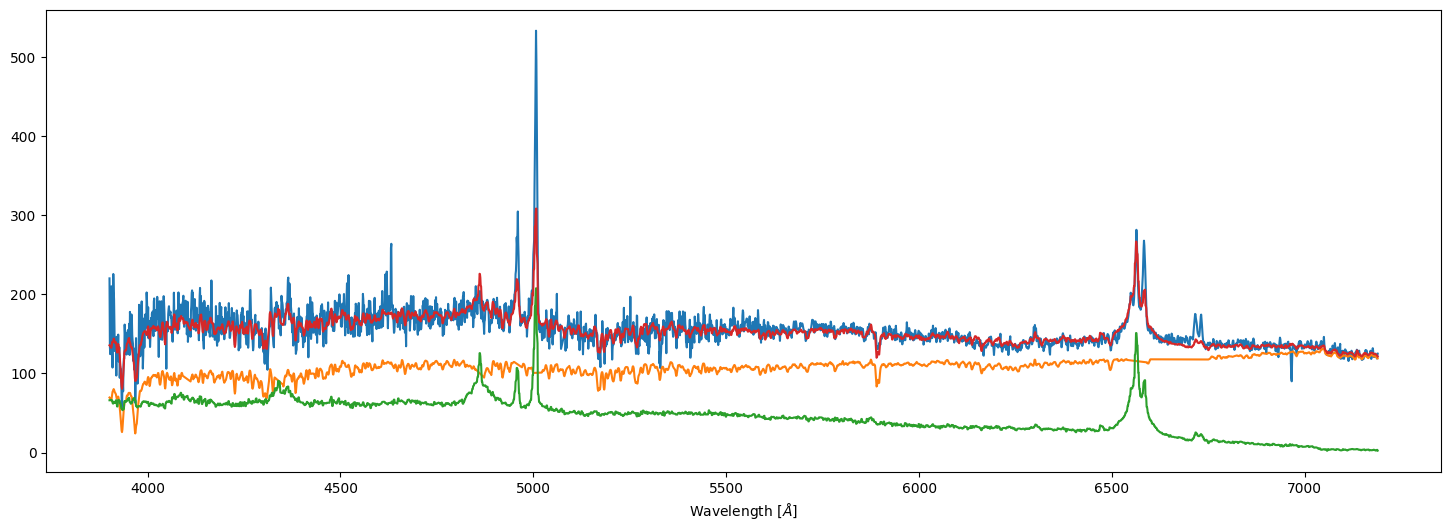

In [12]:
# Let us save the above host, and try fitting with the masked emission lines.
g.host_no_mask=g.host
g.restore()
g.fit_host_sdss(mask_host=True, custom=False)
plt.xlabel(r'Wavelength [$\AA$]')

Text(0.5, 0, 'Wavelength [$\\AA$]')

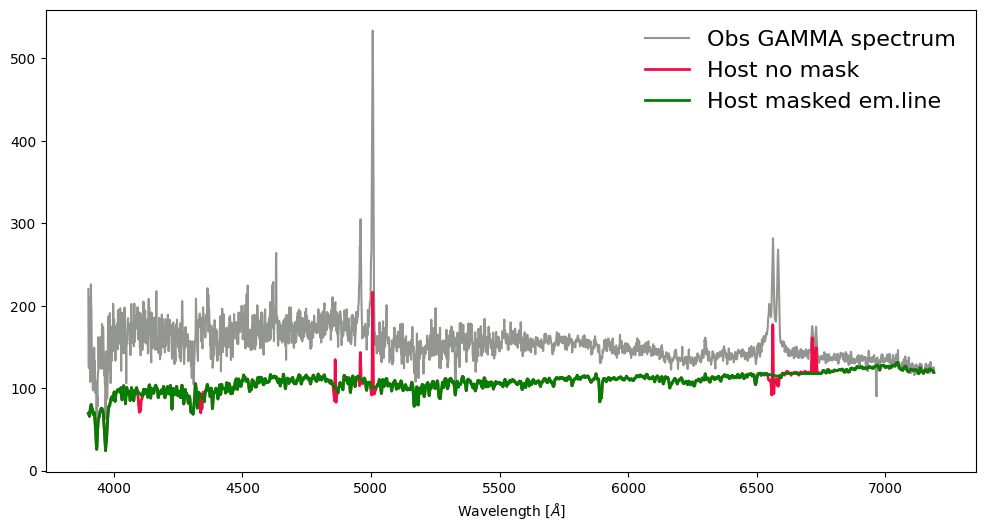

In [13]:
#Let's compare two host-fitting results.

plt.style.context(['nature', 'notebook'])
plt.figure(figsize=(12,6))
plt.plot(g.wave, g.flux+g.host, color="#929591", label='Obs GAMMA spectrum' , lw=1.5)
plt.plot(g.wave, g.host_no_mask, color="#F10C45", label='Host no mask', lw=2)
plt.plot(g.wave, g.host, color="green", label='Host masked em.line', lw=2)
plt.legend(loc='upper right',  prop={'size': 16}, frameon=False)
plt.xlabel(r'Wavelength [$\AA$]')

<font size="4"> 4. Creation of the predefined lists of emission lines </font> 

Within FANTASY there are some standard lists of AGN emission lines, such as: Hydrogen lines (e.g., Ha, Hb, Hg, Hd, Pa, Pb, Pg, Pd), Helium lines (both He I and He II), basic narrow lines ([OIII], [NII]), other AGN narrow lines, other AGN broad lines, Fe II lines, coronal lines, etc. 

For Fe II line we identified several sets: Fe II model (Kovacevic et al. 2010, Shapovalova et al. 2012), list (_feii_IZw1.csv_) of specific I Zw 1 lines, identified by Kovacevic et al. (2010) template, which all originate from the same region. In case of very strong Fe II emitters, such as NLSy1 galaxies, sometimes it is necessary to include additional transitions from forbidden Fe II (see Veron-Cetty et al. 2004).

The command `create_input_folder(xmin,xmax,path_to_folder)` creates a folder in the specified path, copies the predefined line lists within the specified wavelength range.

**IMPORTANT:** If the folder already exsists, it will be overwritten, which can be avoided by using the parameter overwrite=False.

**TIP:** Users can extend/shorten these line lists, as well as create completly new ones.

In [14]:
create_input_folder(xmin=4000,xmax=8000, path_to_folder='liness/')
#create_input_folder(xmin=4000,xmax=8000, path_to_folder='lines/',overwrite=False)

Directory  liness/  Created 


**Note:** Debugging required adding `import glob` in `/home/fran/miniconda3/envs/fantasyenv/lib/python3.9/site-packages/fantasy_agn/models.py` and restarting the kernel.

In [15]:
# Crop function cuts the spectrum in a set wavelength range, e.g., if you want to fit just 
# one emission line or a certain wavelength range

s.crop(4000, 8000)
print(s.wave) # simple examination of the wavelength range

[4000.8545 4001.775  4002.6953 ... 7695.817  7697.593  7699.3633]


<font size="4"> 5. Defining the fitting model </font> 

Basic and simple model for AGN spectra fittings, should contain:
- underlying continuum (broken power-law, power-law, straight line)
- emission line (narrow, broad)

Depending on the wavelength range, spectral quality (S/N ratio, spectral resolution), and object type, the fitting model can be customized to contain many and complex emission features. One example for a **typical type 1 AGN** is given here.

Below we describe the fitting components: 
- `continuum()` - calls `BrokenPowerlaw()` model for a given breaking point (parameter *refer* indicates the breaking wavelength) in the form of: $$ f(\lambda) =\begin{cases} amplitude \cdot \left(\frac{\lambda}{refer}\right)^{index1} & \lambda > refer \\
 amplitude \cdot \left(\frac{\lambda}{refer}\right)^{index1+index2} & \lambda < refer 
\end{cases}$$This means that the power law of *index1* is fitting the part of the spectrum with wavelengths larger than the breaking point, and that of  (*index1* + *index2*) is fitting the part of the spectra with wavelengths smaller than than the breaking point; the continuum amplitude is then automatically set based on the flux value at the breaking point; 

- `create_fixed_model` - calls all lines from the indicated list (which have the same width and shift); user can specify common name for these lines (parameter *name*);

- `create_tide_model` - calls all lines are having width and shift tided to the reference line (typically [OIII] 5007 line); user can specify common name for these lines (parameter *prefix*);

- `create_feii_model` - calls for the FeII model, in which all iron lines have the same width and shift;

- `create_line` - calls single line at the given wavelength (parameter *position*), with possibility to set width (FWHM), shift (*offset*) and intensity (*ampl*);

- `create_model` - calls all lines from the indicated list, but no parameter is constrained;

For multi-line models, user can call a single line-list and many line-lists using the option files=['list1.csv','list2.csv'].

There are many options to limit the fitting parameters (as illustrated in the example below), such as *max_fwhm* set the maximum of the line width to a given value, *min_offset* fix the minimum line shift, etc.

In [16]:
cont=continuum(s,min_refer=5690, refer=5700, max_refer=5710)
broad=create_fixed_model(['hydrogen.csv'], name='br')
he=create_fixed_model(['helium.csv'], name='he',fwhm=3000, min_fwhm=1000, max_fwhm=5000)
narrow=create_tied_model(name='OIII5007',files=['narrow_basic.csv','hydrogen.csv'],prefix='nr', fwhm=1000,min_offset=0, max_offset=300, min_fwhm=900, max_fwhm=1200,fix_oiii_ratio=True, position=5006.803341, included=True,min_amplitude=0.2)
fe=create_feii_model(name='feii', fwhm=1800, min_fwhm=1000, max_fwhm=2000, offset=0, min_offset=-3000, max_offset=3000)
#fe.amp_b4p.min=10 #An example how to force the amplitude of a selected FeII multiplet.

In [17]:
# Code fits simultaneously all features.
model = cont+broad+narrow+fe+he

<font size="4"> 6. Fittings </font> 

Command `s.fit()` performs fittings of the spectrum, which is based on Python's Sherpa package, with the above defined model. The code offers the possibility to set the number of consequent fittings (option `ntrial`) to increase the convergence, given with the chi-squared, which is listed.

In [18]:
s.fit(model, ntrial=2)

stati 404186.8992670696
1 iter stat:  183.25015808682838
2 iter stat:  94.56819641410948


<font size="4"> 7. Plotting the results </font> 

You can plot the results using your favorite plotting style, an example is given below.

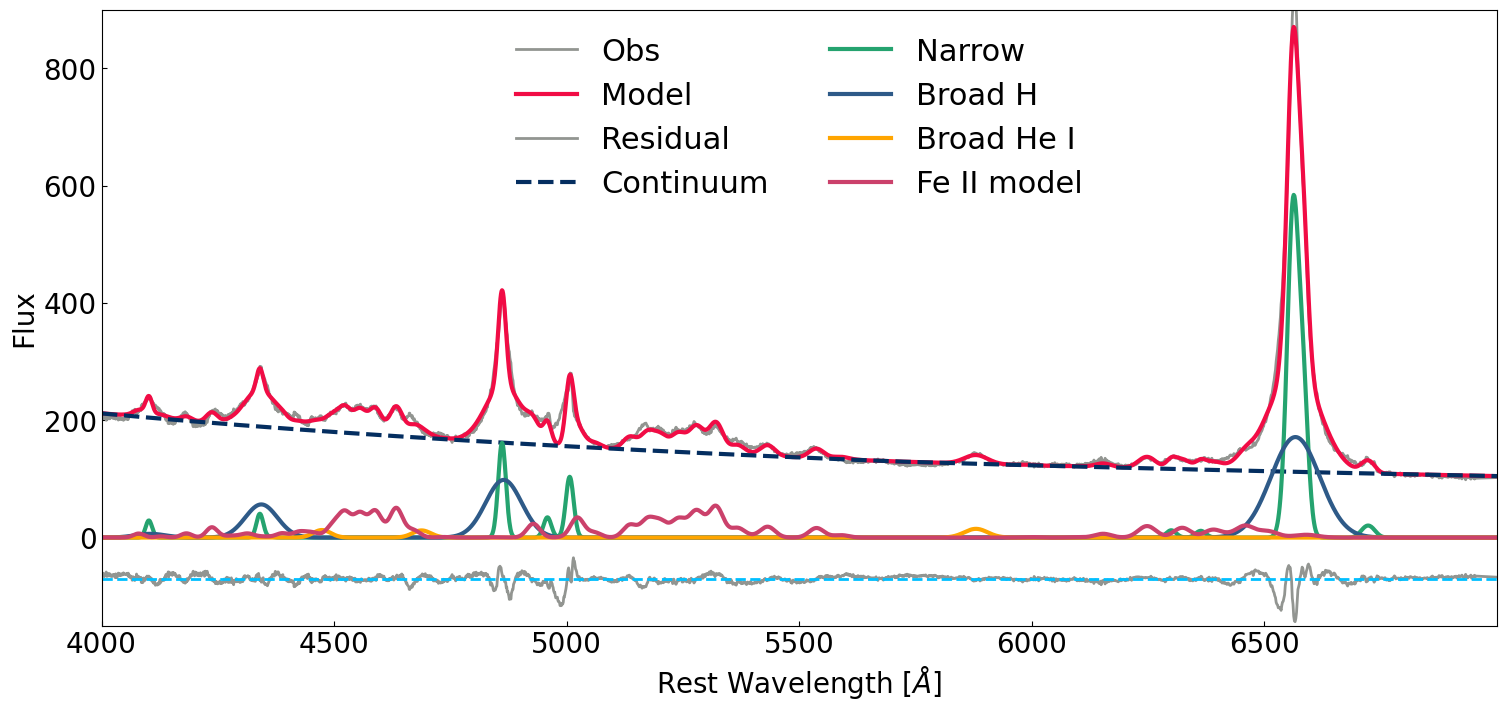

In [19]:
plt.style.context(['nature', 'notebook'])
plt.figure(figsize=(18,8))
plt.plot(s.wave, s.flux, color="#929591", label='Obs', lw=2)
plt.plot(s.wave, model(s.wave), color="#F10C45",label='Model',lw=3)
plt.plot(s.wave, model(s.wave)-s.flux-70, '-',color="#929591", label='Residual', lw=2)
plt.axhline(y=-70, color='deepskyblue', linestyle='--', lw=2)

plt.plot(s.wave, cont(s.wave),'--',color="#042E60",label='Continuum', lw=3)
plt.plot(s.wave, narrow(s.wave),label='Narrow',color="#25A36F",lw=3)
plt.plot(s.wave, broad(s.wave), label='Broad H', lw=3, color="#2E5A88")
plt.plot(s.wave, he(s.wave), label='Broad He I', lw=3, color="orange")
plt.plot(s.wave, fe(s.wave),'-',color="#CB416B",label='Fe II model', lw=3)

plt.xlabel('Rest Wavelength [$\AA$]',fontsize=20)
plt.ylabel('Flux',fontsize=20)
plt.xlim(4000,7000)
plt.ylim(-150,900)
plt.tick_params(which='both', direction="in")
plt.yticks(fontsize=20)
plt.xticks(np.arange(4000, 7000, step=500),fontsize=20)
plt.legend(loc='upper center',  prop={'size': 22}, frameon=False, ncol=2)

plt.savefig('fantasy_fit.pdf')

<font size="4"> 8. Inspecting/saving the fitting results </font> 

To examine the fitting results, simply use the command `model`, which will display all the parameters for each emission line. Note that for complex model, for which the name/prefix has been indicated when defining the model.

In [20]:
model

<BinaryOpModel model instance '((((brokenpowerlaw + br) + (((((((((((((nr_OIII5007 + nr_OIII4958) + nr_NII6584) + nr_NIII6548) + nr_[OIII]_4363) + nr_[OI]_6300) + nr_[OI]_6363) + nr_[SII]_6716) + nr_[SII]_6730) + nr_[OII]_7330) + nr_Hd_4101) + nr_Hg_4340) + nr_Hb_4861) + nr_Ha_6562)) + feii) + he)'>

To see the fitting results, one can use standard outputs from Sherpa package, such as:
- `gres` - to list all fitting results
- `gres.parnames` - to list all parameters
- `save_json()` - to save the results

In [21]:
print(s.gres.format())
s.save_json() #saving parameters 

Method                = levmar
Statistic             = chi2
Initial fit statistic = 13757.4
Final fit statistic   = 13662.8 at function evaluation 942
Data points           = 2844
Degrees of freedom    = 2792
Probability [Q-value] = 0
Reduced statistic     = 4.89355
Change in statistic   = 94.5682
   brokenpowerlaw.refer   5710         +/- 33.4499     
   brokenpowerlaw.ampl   129.739      +/- 0.916425    
   brokenpowerlaw.index1   -1.37532     +/- 0.00746476  
   brokenpowerlaw.index2   0.328635     +/- 0.0116827   
   br.amp_Hd_4102   6.3904       +/- 1.18437     
   br.amp_Hg_4340   56.5233      +/- 2.19634     
   br.amp_Hb_4861   98.2932      +/- 0.841049    
   br.amp_Ha_6563   171.356      +/- 1.60169     
   br.offs_kms    214.037      +/- 8.33898     
   br.fwhm        5614.38      +/- 26.8242     
   nr_OIII5007.ampl   103.621      +/- 1.00432     
   nr_OIII5007.offs_kms   0            +/- 3.13082     
   nr_OIII5007.fwhm   1200         +/- 8.59872     
   nr_NII6584.ampl  

<font size="4"> 9. Simple analysis </font> 

Here we demonstrate how to measure the fluxes of a model component.

In [22]:
# Integrate total FeII model
flux_feII=np.sum(fe(s.wave))
print("FeII total flux=",flux_feII)

# Mask the wavelength range of interest (e.g. Ha line) and integrate broad component.
x=s.wave
mask_ha=(x>6300)&(x<6700)
Ha_broad=np.sum(broad(s.wave)[mask_ha])
print("Ha_broad=",Ha_broad)

FeII total flux= 23445.965
Ha_broad= 14761.952


**References**

1. [Rakic, N., 2022, MNRAS, 516, 1624](https://ui.adsabs.harvard.edu/abs/2022MNRAS.516.1624R/abstract)
2. [Ilic, D. et al. 2020, A&A, 638, 13](https://ui.adsabs.harvard.edu/abs/2020A%26A...638A..13I/abstract)
3. [Kovacevic, J. et al. 2010, ApJS, 189, 15](https://ui.adsabs.harvard.edu/abs/2010ApJS..189...15K/abstract)
4. [Shapovalova, A. I. et al. 2012, ApJS, 202, 10](https://ui.adsabs.harvard.edu/abs/2012ApJS..202...10S/abstract)
5. Ilic, D., Rakic, N., Popovic, L. C., 2023, ApJS, in press


## Exercise:

**Select one type 1 AGN from SDSS and re-run through the general tutorial using this new spectrum.**

We select an AGN from the [SDSS quasar catalog, sixteenth data release (DR16Q)](https://vizier.cds.unistra.fr/viz-bin/VizieR?-source=VII/289) by [Lyke et al. 2020](https://cdsarc.cds.unistra.fr/viz-bin/cat/VII/289#/history), choosing the closest [SDSS object](https://dr16.sdss.org/optical/spectrum/view?plateid=6498&mjd=56565&fiberid=898) at redshift $z=0.389015$, on Plate: 6498, 
MJ: 	5656 and 
Fiber: D	8.$.68

In [40]:
s=read_sdss('spec-6498-56565-0898.fits')

Note that these wavelengths are transformed from vacuum to air wavelengths by default.

In [41]:
#check the redshift
s.z

0.389015

In [42]:
#correct for galactic extinction
s.DeRedden()

In [43]:
#correct for cosmological redshift
s.CorRed()

In [44]:
s.fit_host_sdss()

Host contribution is negliglable


In [45]:
s.restore() #command to restore the spectrum before host galaxy fitting and substraction
s.fit_host_sdss(mask_host=True, custom=False)

Host contribution is negliglable


In [46]:
create_input_folder(xmin=4000,xmax=8000, path_to_folder='liness/')
#crop the spectrum to the range in which the eigenvectors are provided
s.crop(4000, 8000)
print(s.wave) # simple examine of the wavelength range

Directory  liness/  already exists
[4000.1155 4001.0354 4001.9583 ... 7472.643  7474.358  7476.0825]


Text(0.5, 0, 'Wavelength [$\\AA$]')

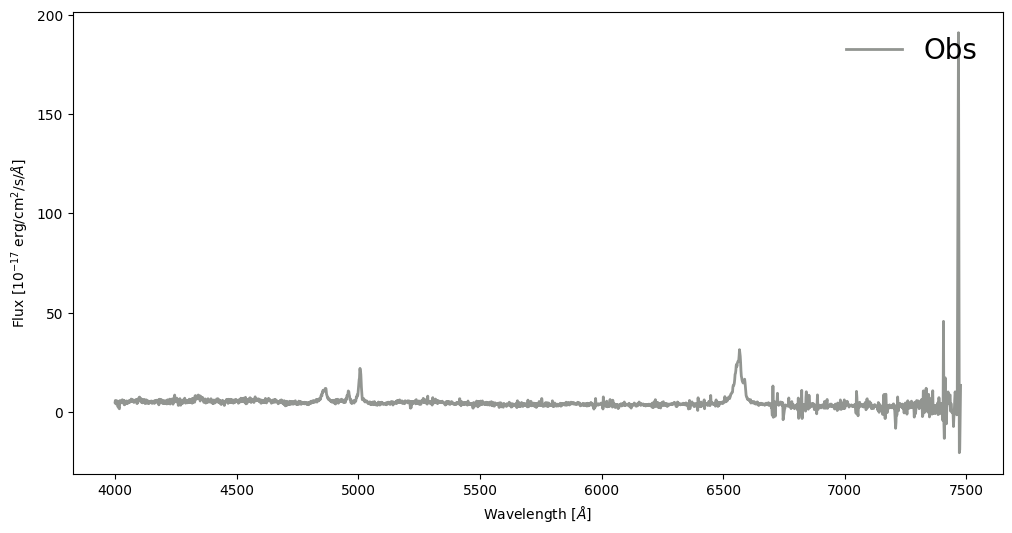

In [47]:
#Plot the spectrum for visual inspection.
plt.style.context(['nature', 'notebook'])
plt.figure(figsize=(12,6))
plt.plot(s.wave, s.flux, color="#929591", label='Obs', lw=2)
plt.legend(loc='upper right',  prop={'size': 20}, frameon=False, ncol=2)
plt.ylabel(r'Flux [10$^{-17}$ erg/cm$^{2}$/s/$\AA$]')
plt.xlabel(r'Wavelength [$\AA$]')

In [48]:
cont=continuum(s,min_refer=5690, refer=5700, max_refer=5710)
broad=create_fixed_model(['hydrogen.csv'], name='br')
he=create_fixed_model(['helium.csv'], name='he',fwhm=3000, min_fwhm=1000, max_fwhm=5000)
narrow=create_tied_model(name='OIII5007',files=['narrow_basic.csv','hydrogen.csv'],prefix='nr', fwhm=1000,min_offset=0, max_offset=300, min_fwhm=900, max_fwhm=1200,fix_oiii_ratio=True, position=5006.803341, included=True,min_amplitude=0.2)
fe=create_feii_model(name='feii', fwhm=1800, min_fwhm=1000, max_fwhm=2000, offset=0, min_offset=-3000, max_offset=3000)

In [49]:
# Code fits simultaneously all features.
model = cont+broad+narrow+fe+he

In [50]:
s.fit(model, ntrial=2)

stati 37186.639211792644
1 iter stat:  22691.77682872993
2 iter stat:  87.38939636896612


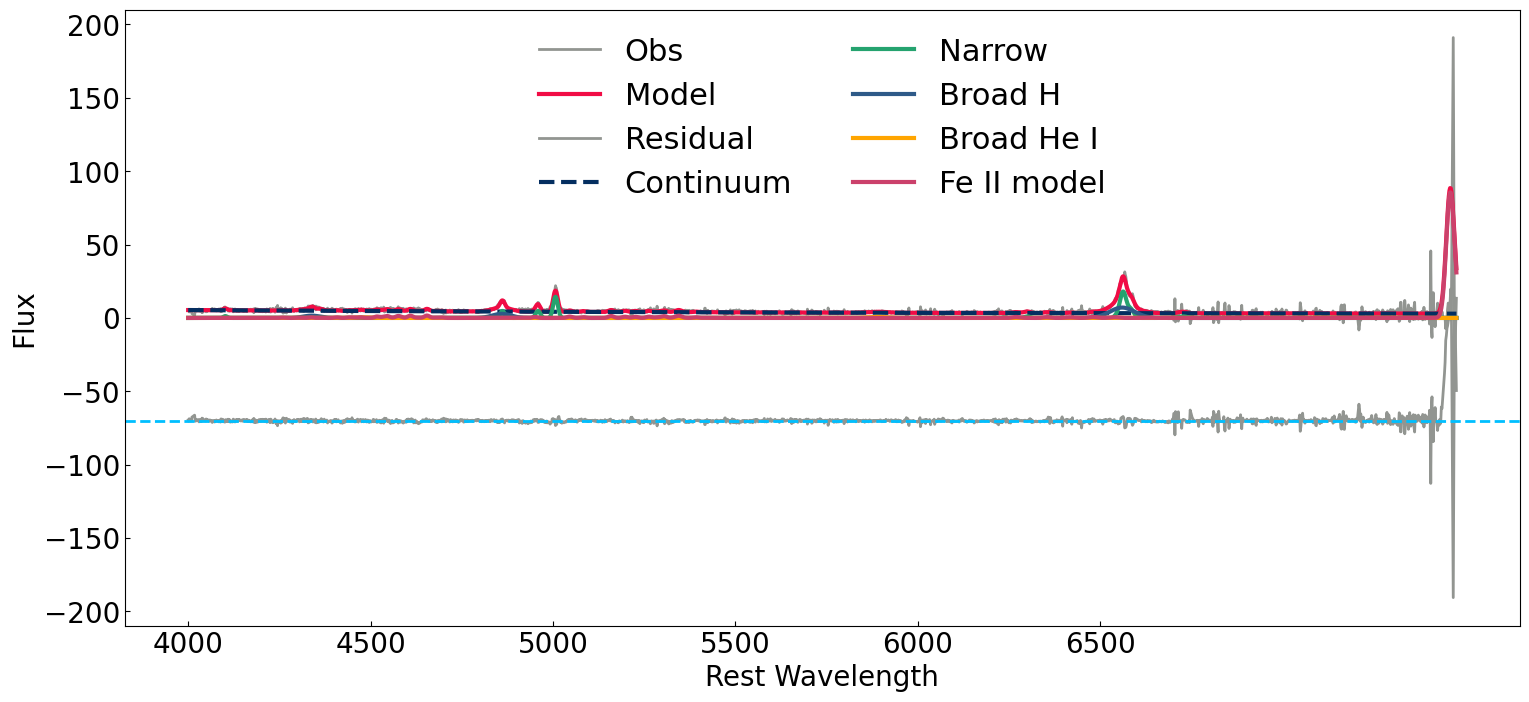

In [51]:
plt.style.context(['nature', 'notebook'])
plt.figure(figsize=(18,8))
plt.plot(s.wave, s.flux, color="#929591", label='Obs', lw=2)
plt.plot(s.wave, model(s.wave), color="#F10C45",label='Model',lw=3)
plt.plot(s.wave, model(s.wave)-s.flux-70, '-',color="#929591", label='Residual', lw=2)
plt.axhline(y=-70, color='deepskyblue', linestyle='--', lw=2)

plt.plot(s.wave, cont(s.wave),'--',color="#042E60",label='Continuum', lw=3)
plt.plot(s.wave, narrow(s.wave),label='Narrow',color="#25A36F",lw=3)
plt.plot(s.wave, broad(s.wave), label='Broad H', lw=3, color="#2E5A88")
plt.plot(s.wave, he(s.wave), label='Broad He I', lw=3, color="orange")
plt.plot(s.wave, fe(s.wave),'-',color="#CB416B",label='Fe II model', lw=3)

plt.xlabel('Rest Wavelength',fontsize=20)
plt.ylabel('Flux',fontsize=20)
#plt.xlim(4000,7000)
#plt.ylim(-150,900)
plt.tick_params(which='both', direction="in")
plt.yticks(fontsize=20)
plt.xticks(np.arange(4000, 7000, step=500),fontsize=20)
plt.legend(loc='upper center',  prop={'size': 22}, frameon=False, ncol=2)

plt.savefig('fantasy_fit2.pdf')

In [52]:
#check model
model

<BinaryOpModel model instance '((((brokenpowerlaw + br) + (((((((((((((nr_OIII5007 + nr_OIII4958) + nr_NII6584) + nr_NIII6548) + nr_[OIII]_4363) + nr_[OI]_6300) + nr_[OI]_6363) + nr_[SII]_6716) + nr_[SII]_6730) + nr_[OII]_7330) + nr_Hd_4101) + nr_Hg_4340) + nr_Hb_4861) + nr_Ha_6562)) + feii) + he)'>

In [53]:
print(s.gres.format())
s.save_json() #saving parameters

Method                = levmar
Statistic             = chi2
Initial fit statistic = 18383.9
Final fit statistic   = 18296.5 at function evaluation 1064
Data points           = 2717
Degrees of freedom    = 2665
Probability [Q-value] = 0
Reduced statistic     = 6.86549
Change in statistic   = 87.3894
   brokenpowerlaw.refer   5710         +/- 333.852     
   brokenpowerlaw.ampl   3.62942      +/- 0.215424    
   brokenpowerlaw.index1   -1.10305     +/- 0.0457725   
   brokenpowerlaw.index2   0.259294     +/- 0.118868    
   br.amp_Hd_4102   0.0474684    +/- 0.157709    
   br.amp_Hg_4340   1.58064      +/- 0.190061    
   br.amp_Hb_4861   2.80196      +/- 0.130996    
   br.amp_Ha_6563   7.07687      +/- 0.343159    
   br.offs_kms    -129.062     +/- 31.2625     
   br.fwhm        3602.85      +/- 91.135      
   nr_OIII5007.ampl   14.4379      +/- 0.250795    
   nr_OIII5007.offs_kms   4.48477e-05  +/- 0           
   nr_OIII5007.fwhm   901.289      +/- 13.512      
   nr_NII6584.ampl 

In [54]:
# Integrate total FeII model,
flux_feII=np.sum(fe(s.wave))
print("FeII total flux=",flux_feII)

# Mask the wavelength range of interess (e.g. Ha line) and integrate broad component.
x=s.wave
mask_ha=(x>6300)&(x<6700)
Ha_broad=np.sum(broad(s.wave)[mask_ha])
print("Ha_broad=",Ha_broad)

FeII total flux= 1711.5791
Ha_broad= 393.315
